In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import base64
from io import BytesIO

from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import implicit
from scipy.sparse import csr_matrix
from implicit.nearest_neighbours import tfidf_weight

import requests
import bs4

from IPython.display import Image, display, HTML
HTML('''
<style>
.small-caps {
    font-variant: small-caps;
}
.custom-header {
        display: flex;
        justify-content: space-between;
        align-items: center;
        background: linear-gradient(45deg, 
            #4EB3E7, #62D0EB, #65D498);
        color: #FFF;
        padding: 0px 20px 5px;
        width: 100%;
        font-size: 20px;
        font-family: Times New Roman;
        font-weight: bold;
        color: white;
        }
</style>
<script
    src="https://cdnjs.cloudflare.com/ajax/libs/jquery/2.0.3/jquery.min.js ">
</script>
<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.jp-CodeCell > div.jp-Cell-inputWrapper').hide();
 } else {
$('div.jp-CodeCell > div.jp-Cell-inputWrapper').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit"
    value="Click here to toggle on/off the raw code."></form>
''')

In [2]:
def plot_to_html(alt_text):
    """Display the current figure as a centered html image

    Parameters
    ----------
    alt_text: str
        The alternative text for the image displayed
    """
    fig = plt.gcf()
    buf = BytesIO()
    plt.savefig(buf, format='png')
    plt.close()
    fig = base64.b64encode(buf.getvalue()).decode('utf-8')
    html = f'''<div style="text-align: center;">
                   <img src="data:image/png;base64,{fig}"
                        alt="{alt_text}"/>
                   </div>'''
    display(HTML(html))


# Metric functions
def calculate_hit_ratio(articles_read, articles_recommended):
    """Calculate the hit ratio metric given the articles read and the
    recommendations made"""
    relevant_count = len(set(articles_read) & set(articles_recommended))
    hit_ratio = relevant_count / len(articles_recommended)
    return hit_ratio


def calculate_precision(articles_read, articles_recommended, k):
    """Calculate the precision metric given the articles read and the
    recommendations made"""
    k = min(k, len(articles_recommended))
    relevant_count = len(set(articles_read) & set(articles_recommended[:k]))
    precision = relevant_count / k
    return precision


def calculate_recall(articles_read, articles_recommended, k):
    """Calculate the recall metric given the articles read and the
    recommendations made"""
    k = min(k, len(articles_recommended))
    relevant_count = len(set(articles_read) & set(articles_recommended[:k]))
    recall = relevant_count / len(articles_read)
    return recall


def calculate_nDCG(articles_read, articles_recommended, k):
    """Calculate the nDCG metric given the articles read and the
    recommendations made"""
    relevance = [
        1 if article in articles_read else 0
        for article in articles_recommended]
    k = min(k, len(relevance))
    dcg = relevance[0] + np.sum(relevance[1:k] / np.log2(np.arange(2, k+1)))

    ideal_relevance = np.ones(len(articles_read))
    idcg = ideal_relevance[0] + np.sum(
        ideal_relevance[1:len(articles_read)] /
        np.log2(np.arange(2, len(articles_read) + 1)))

    if idcg == 0:
        ndcg = 0
    else:
        ndcg = dcg / idcg

    return ndcg


def calculate_RR(articles_read, articles_recommended):
    """Calculate the Reciprocal Rank metric given the articles read and the
    recommendations made"""
    rr = 0
    for index, article in enumerate(articles_recommended, start=1):
        if article in articles_read:
            rr = 1 / index
            break
    return rr

# Function to calculate all metrics for given recommendations and ground truth


def calculate_metrics(ground_truth, recommendations, k=10):
    """Calculate different metrics given the ground truth and the
    recommendations made"""
    metrics_list = []
    for user, articles_read in ground_truth.items():
        if user in recommendations:
            articles_recommended = recommendations[user]
            metrics_list.append({
                'user': user,
                'hit_ratio': calculate_hit_ratio(
                    articles_read, articles_recommended),
                'precision': calculate_precision(
                    articles_read, articles_recommended, k),
                'recall': calculate_recall(
                    articles_read, articles_recommended, k),
                'nDCG': calculate_nDCG(
                    articles_read, articles_recommended, k),
                'RR': calculate_RR(
                    articles_read, articles_recommended)
            })
    return pd.DataFrame(metrics_list)


def sample_columns_per_row(df, num_columns=10):
    """Samples up to 'num_columns' non-zero columns per row from
    DataFrame 'df'."""
    result = {}
    rng = np.random.default_rng(seed=0)
    for idx, row in df.iterrows():
        click_columns = row.index[row > 1]
        if len(click_columns) >= num_columns:
            sampled_columns = rng.choice(
                click_columns, num_columns, replace=False).tolist()
        else:
            sampled_columns = rng.choice(
                click_columns, len(click_columns), replace=False).tolist()
        result[idx] = sampled_columns
    return result


def recommend_popular(df, user, L=None):
    """
    Recommend popular items to a user.

    Parameters
    ----------
    df : pandas.DataFrame
        Utility matrix with user-item interactions.
    user : str
        User identifier.
    L : int, optional
        Number of items to recommend. If None, recommends items to fill 
        missing values.

    Returns
    -------
    list
        List of recommended items.
    """
    reco = []
    popular = pop_list.copy()
    if L is None:
        L = np.isnan(df_utility.loc[user]).sum()
    while len(reco) < L:
        item = popular.pop(0)
        if df.at[user, item] == 0:
            reco.append(item)

    return reco


def recommend_recent(df, user, L=None):
    """
    Recommend popular items to a user.

    Parameters
    ----------
    df : pandas.DataFrame
        Utility matrix with user-item interactions.
    user : str
        User identifier.
    L : int, optional
        Number of items to recommend. If None, recommends items to fill 
        missing values.

    Returns
    -------
    list
        List of recommended items.
    """
    reco = []
    recent = most_recent_unique.copy()
    if L is None:
        L = np.isnan(df_utility.loc[user]).sum()
    while len(reco) < L:
        item = recent.pop(0)
        if df.at[user, item] == 0:
            reco.append(item)

    return reco


def calculate_metrics_als(ground_truth, recommendations, k=10):
    """Calculate the metrics for ALS"""
    metrics_list = []
    for user, articles_read in ground_truth.items():
        if user in recommendations:
            articles_recommended = recommendations[user]
            metrics_list.append({
                'user': user,
                'hit_ratio': calculate_hit_ratio(
                    articles_read, articles_recommended),
                'precision': calculate_precision(
                    articles_read, articles_recommended, k),
                'recall': calculate_recall(
                    articles_read, articles_recommended, k),
                'nDCG': calculate_nDCG(
                    articles_read, articles_recommended, k),
                'RR': calculate_RR(
                    articles_read, articles_recommended)
            })
    return pd.DataFrame(metrics_list).describe()


def add_newline_in_middle(sentence):
    """Add newline character in the middle of the string"""
    words = sentence.split()
    middle_index = len(words) // 2
    return (
        ' '.join(words[:middle_index]) + '\n' + ' '.join(words[middle_index:])
    )


def get_read_news(user_id):
    """Get the information of articles read by the user"""
    user_read = (df_new
                 .loc[user_id][df_new.loc[user_id] == 41]
                 .head(10)
                 .index
                 .tolist())
    return df_train_news[df_train_news['News_ID'].isin(user_read)].iloc[:, 1:4]


def get_reco_news(user_id):
    """Get the information of recommended articles"""
    return (df_train_news[df_train_news['News_ID']
            .isin(user_recommendations_als[user_id])]
            .iloc[:, 1:4])

![Cover Photo](Cover.png)

<div class="custom-header">
    <h1 class="small-caps"><a name='abstract'>Abstract</a></h1>
</div>

In today's competitive education landscape,  learning institutions have increasingly turned to digital marketing as a cost-effective strategy to boost brand credibility and admission rates. This study examines how the Asian Institute of Management (AIM), a globally recognized learning institution, can enhance its brand recognition through digital platforms. We focus on Wikipedia, one of the most visited websites, known for its open-access model, making it an invaluable free marketing tool.

Leveraging 7 years' worth of Wikipedia clickstream data related to AIM, our analysis revealed that articles about affiliated personalities serve as the primary driver of internal traffic to AIM's Wikipedia page, while external traffic predominantly originates from search results. Notably, the notable alumni section garners significant attention, indicating strong visitor interest. AIM can capitalize on this by maximizing backlinks from articles about affiliated personalities and improving page content. This strategy can boost AIM's brand recognition and potentially redirect visitors to AIM's website, providing an opportunity to showcase more of the institution to prospective students.

Future research could delve deeper into the interconnectedness between AIM and its related entities. Furthermore, studies can also explore metrics beyond clicks, such as views and engagement, to gain a comprehensive understanding of AIM's online marketing strategies.

<div class="custom-header">
    <h1 class="small-caps"><a name='background'>Background</a></h1>
</div>

Newspapers have long been a staple in most people's daily routines. They used to be the primary source of news before the invention of the internet. The first instance of a newspaper can be traced back
from 1609 with the publication of <b>Relation</b>, a german language newspaper in Strasborg published by Johann Carolus$^{[1]}$. However, with the growth of online news sources, newspapers have become less popular as more people turn to the internet for their daily updates and information.
  
In recent years, there has been a significant shift in how people consume news. People are moving away from traditional print media and going towards
digital formats. According to newspaper sales statistics, global revenue from print newspapers and magazines is expected to decline by 13.05%,
dropping from 127.20 billion USD in 2023 to 110.60 billion USD by 2027. In contrast, digital newspaper and magazine revenue is projected to grow by 11.37%,
increasing from 38.60 billion USDin 2023 to 42.99 billion USD by 2027$^{[2]}$.  

Online news has been around for quite some time. <i>The Columbus Dispatch</i> published their first online newspaper in 1980, but it was <i>CNN</i> that really paved the way for the digital transformation of news.$^{[3]}$. The prevalence of online news today can be attributed today to several factors. The affordability and increased speed of internet connections have made digital news more accessible. Additionally, the widespread use of smartphones allows people to access news on the go, accelerating the move to digital platforms. In the Philippines, most newspaper companies have their own
digital implementation, albeit a more competitive market since they also compete with the internet versions of television and radio news.

The digital migration of news attracted the attention of major internet players such as Yahoo, Microsoft's MSN. Yahoo and MSN either created their own news
articles or linked external news sources to their own pages, increasing the utility and attractability of their platforms. Today, the first thing a person sees
when they open a Microsoft Edge browser is a personalized news feed. This implementation allows Microsoft to earn through advertisment articles and links
intermingled with genuine news articles as shown in <b>Figure 1</b>.  

A Forbes article declares that <i>"Microsoft has quietly become the next ad-tech giant"</i>. Microsoft has a diverse collection of platforms like Bing, Edge, MSN, XboX, Teams, GitHub, Outlook and more, allowing them to efficiently deploy advertisements$^{[4]}$. Most of these platforms can incorporate a common newsfeed system particularly Bing, Edge, and Microsoft Edge, all of which can deploy advertisements. On April 20, 2020, Microsoft released an open dataset of Microsoft News along with user impressions, this is a huge repository of data that they can used to add value to their business.

<div style="text-align:center;">
    <img src="edge.png" alt="MS Edge News">
</div>
<br>
<center><b>Figure 1. </b>Microsoft Edge Newsfeed with Advertisement Links</center>

<div class="custom-header">
    <h1 class="small-caps"><a name='problem_statement'>Problem Statement</a></h1>
</div>

The migration of newspapers to online platforms has transformed the manner in which news is disseminated. Previously, news articles were distributed in the form of a newspaper bundle, but online delivery enables a more sophisticated method. News is commonly presented in a newsfeed, where only the most important and relevant articles are shown. For online news platforms, suggesting articles to read is a major problem. Ensuring the relevance and appeal of news articles displayed in a user's newsfeed is crucial for retaining that user. News articles are seldom subject to ratings, unlike movies and books. In addition, the large quantity of news articles produced daily renders explicit ratings unfeasible.  

Given the rising demand and interest on online news platforms and the potential revenue of being a top provider of such, the question now is:

<center><b>"How can online news platforms recommend news that are relevant to the users without the presence of explicit ratings?"</center>

<div class="custom-header">
    <h1 class="small-caps"><a name='motivation'>Motivation</a></h1>
</div>

The motivation for this project is to enhance user engagement and satisfaction on online news platforms. With the increasing volume of news content generated daily, it is crucial to deliver relevant and personalized news articles to users. By developing an effective recommendation system that does not rely on explicit user ratings, the project aims to:  

1. <b>Improve User Experience:</b> Delivering relevant content will keep users engaged and satisfied, encouraging them to spend more time on the platform.

2. <b>Increase Retention Rates:</b> Providing personalized newsfeeds can help retain users, reducing the likelihood of them switching to competing platforms.

3. <b>Address the Challenge of Explicit Ratings:</b> Since users are generally not inclined to rate news articles, creating a recommendation system that works without explicit feedback is essential.

4. <b>Stay Competitive:</b> In a highly competitive market, especially with the digital presence of traditional media like television and radio, an advanced recommendation system can give an online news platform a significant edge.

5. <b>Leverage Data Effectively:</b> Utilizing advanced algorithms and machine learning techniques can help in making sense of large datasets, providing insights that can drive further innovation in content delivery.  

6. <b>Increase Ad Engagement:</b> Increased user traffic can increase the desirabilty of the platform to advertisers. This can increase the amount of advertisements the platform runs, or even increase the cost of advertising in their platform.

<div class="custom-header">
    <h1 class="small-caps"><a name='data_source'>Data Source</a></h1>
</div>

The primary dataset used in this project is **Mi**crosoft **N**ews **D**ataset **(MIND)**. It is a large-scale dataset for news recommendation research collected from anonymized behavior logs of Microsoft News website.  

**MIND** contains about 160k English news articles and more than 15 million impression logs generated by 1 million users. Every news article contains rich textual content including title, abstract, body, category, and entities. Each impression log contains the click events, non-clicked events, and historical news click behaviors of this user before this impression. To protect user privacy, each user was de-linked from the production system when securely hashed into an anonymized ID.  

However, due to time and computational constraints, this study will be using **MiND-small**. It is a smaller version of the **MiND** dataset generated by
sampling 50,000 users and their behavior logs.

More information can be checked on this link: https://msnews.github.io/index.html

<div class="custom-header">
    <h1 class="small-caps"><a name='data_description'>Data Description</a></h1>
</div>

The dataset is comprised of a train and test folder, but for this project only the train folder will be used. This study will make use of two files from the dataset namely:
- **behavior.tsv:** The click histories and impression logs of users.
- **news.tsv:** the information of news articles.

### behavior

The description of the features is `behavior.tsv` is shown on Table 1.

| Feature       | Description                                                                                                     |
|---------------|-----------------------------------------------------------------------------------------------------------------|
| Impression ID | The ID of an impression.                                                                                        |
| User ID       | The anonymous ID of a user.                                                                                     |
| Time          | The impression time with format “MM/DD/YYYY HH:MM:SS AM/PM”.                                                    |
| History       | The news click history (ID list of clicked news) of this user before this impression.                           |
| Impressions   | List of news displayed in this impression and user’s click behaviors on them (1 for click and 0 for non-click). |                            

<center><b>Table 1. </b>  List and Description of Features in the behavior.tsv </center>


### news

The description of the features is `news.tsv` is shown on Table 2.  

| Feature           | Description                                                                                                     |
|-------------------|-----------------------------------------------------------------------------------------------------------------|
| News ID           | The ID of a news article.                                                                                       |
| Category          | News Category of the article.                                                                                   |
| SubCategory       | The SubCategory of the article.                                                                                 |
| Title             | The Title of the news article.                                                                                  |
| Abstract          | A short description of the article.                                                                             |
| URL               | The link to the article.                                                                                        |
| Title Entities    | Entities contained in the title of the news.                                                                     |
| Abstract Entities | Entities contained in the abstract of the news.                                                                 |

<center><b>Table 2. </b>  List and Description of Features in the news.tsv</center>

<div class="custom-header">
    <h1 class="small-caps"><a name='methodology'>Methodology</a></h1>
</div>

An overview of the steps to be done in the project is found in Figure 2.

<div style="text-align:center;">
    <img src="methodology.png" alt="Methodology Overview Flowchart">
</div>
<br>
<center><b>Figure 2. </b>Methodology Overview</center>

The project's aim is to generate news article recommendations using implicit data, e.g. user click impressions. To achieve this, the team will follow five major steps after data was acquired from the source website. Short description for each step is shown in Table 3.

Exploration of the dataset will be done to understand the MiND dataset. Sanity checks will also be done in this section. Afterwards, data cleaning and preprocess will be done to prepare the utility matrix used in training recommender systems.

The `implicit` python package will be used to train the different implicit models. The models to be considered are the following:
1. Alternating Least Squares (as-is)
2. Alternating Least Squares (TF-IDF)
3. Logistic Matrix Factorization
4. Bayesian Personalized Ranking

Each of the four models will be evaluated using the metrics applicable for Recommender Systems namely:
- Mean Average Precision @ k (MAP@k)
- Normalized Discounted Cumulative Gain (nDCG)
- Mean Reciprocal Rank (MRR)

The final model will be chosen based on the prior evaluation done. News article recommendations from the final model will be extracted for a sample of users to be compared to their historical clicked articles.

||<center>Step</center>|<center>Detailed Description</center>| 
|:---|:---|:---|
|`1`|Data Exploration| Visualize data to extract insights about the business problem|
|`2`|Data Cleaning and Preprocessing| Utility matrix will be created consisting of clicks, non-clicks, and never-seen articles|
|`3`|Implicit Model Training| Implicit Models based on different algorithms were trained using the completed utility matrix |
|`4`|Evaluation of Metrics| After training the different models, several metrics were evaluated for each model to identify the final model to be used. |
|`5`|Recommend News Articles| Using the final trained implicit recommender system model, recommendations of news articles to sample users were made and compared with their clicked articles.|

<center><b>Table 3. </b> Project Pipeline</center>

<div class="custom-header">
    <h1 class="small-caps"><a name='EDA'>Exploratory Data Analysis</a></h1>
</div>

### Load the Dataset

In [3]:
# Name the columns
bhv_cols = ["Impression_ID", "User_ID", "Time", "History", "Impressions"]
nws_cols = ["News_ID", "Category", "SubCategory", "Title",
            "Abstract", "URL", "Title_Entities", "Abstract_Entities"]

# Load the tsv's
df_train_bhv = pd.read_csv("small_data/MINDsmall_train/behaviors.tsv",
                           sep="\t", header=None, names=bhv_cols)
df_train_news = pd.read_csv('small_data/MINDsmall_train/news.tsv',
                            sep='\t', header=None, names=nws_cols)

# Convert Time col to datetime
df_train_bhv["Time"] = pd.to_datetime(df_train_bhv["Time"])

# Extract Usern list
train_users = (
    df_train_bhv['User_ID']
    .value_counts()
    .index
    .tolist()
)

The `behaviors.tsv` file contains behavior logs made by the users. Each behavior log has unique `Impression_ID`, the `User_ID` who made the impressions, `Time` when the behavior was logged, the click `History` of the user as of the time of the behavior log, and the `Impressions` made.

User Impressions were split into two types: **non-clicks** and **click**. Non-clicks are news articles that were observed by the user but were not selected for reading. Non-clicks are denoted with a `0` after the News_ID. For the article that the user eventually selected for reading, this was denoted with a `1`.

In [4]:
df_train_bhv.head()

,Impression_ID,User_ID,Time,History,Impressions
0,1,U13740,2019-11-11 09:05:58,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,2019-11-12 18:11:30,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...
2,3,U73700,2019-11-14 07:01:48,N10732 N25792 N7563 N21087 N41087 N5445 N60384...,N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...
3,4,U34670,2019-11-11 05:28:05,N45729 N2203 N871 N53880 N41375 N43142 N33013 ...,N35729-0 N33632-0 N49685-1 N27581-0
4,5,U8125,2019-11-12 16:11:21,N10078 N56514 N14904 N33740,N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...


**Table 4.** Preview of `behavior.tsv` dataframe showing first 5 rows.

The `news.tsv` file contains the content of each news article such as its unique `News_ID`, `Category`, `SubCategory`, `Title`, among others. For the purpose of this project, this will be used to understand and compare descriptively the recommendations made by the models with the historical clicked articles.

In [5]:
df_train_news.head()

,News_ID,Category,SubCategory,Title,Abstract,URL,Title_Entities,Abstract_Entities
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."
2,N61837,news,newsworld,The Cost of Trump's Aid Freeze in the Trenches...,Lt. Ivan Molchanets peeked over a parapet of s...,https://assets.msn.com/labs/mind/AAJgNsz.html,[],"[{""Label"": ""Ukraine"", ""Type"": ""G"", ""WikidataId..."
3,N53526,health,voices,I Was An NBA Wife. Here's How It Affected My M...,"I felt like I was a fraud, and being an NBA wi...",https://assets.msn.com/labs/mind/AACk2N6.html,[],"[{""Label"": ""National Basketball Association"", ..."
4,N38324,health,medical,"How to Get Rid of Skin Tags, According to a De...","They seem harmless, but there's a very good re...",https://assets.msn.com/labs/mind/AAAKEkt.html,"[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI...","[{""Label"": ""Skin tag"", ""Type"": ""C"", ""WikidataI..."


**Table 5.** Preview of `news.tsv` dataframe showing first 5 rows.

### Null Values Handling

The two dataframes containing the data from `behavior.tsv` and `news.tsv` are checked for null values that might affect the processing of the data during analysis.

In [6]:
df_train_bhv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156965 entries, 0 to 156964
Data columns (total 5 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Impression_ID  156965 non-null  int64         
 1   User_ID        156965 non-null  object        
 2   Time           156965 non-null  datetime64[ns]
 3   History        153727 non-null  object        
 4   Impressions    156965 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(3)
memory usage: 6.0+ MB


The `behavior` data contains missing values for the History column, but this is perfectly fine since at the start a new user's earliest impression entry would have no
corresponding history value. This is because that row contains the user's first impression, meaning the person has no history of news article clicks. This would not
affect the analysis because only the latest timestamp for each user is used to generate the utility matrix.

In [7]:
df_train_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51282 entries, 0 to 51281
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   News_ID            51282 non-null  object
 1   Category           51282 non-null  object
 2   SubCategory        51282 non-null  object
 3   Title              51282 non-null  object
 4   Abstract           48616 non-null  object
 5   URL                51282 non-null  object
 6   Title_Entities     51279 non-null  object
 7   Abstract_Entities  51278 non-null  object
dtypes: object(8)
memory usage: 3.1+ MB


The `news` data also contains missing values but for the Abstract column. This does not directly affect the creation of the recommendation system since, we are not using any content based recommendation sytem.

### Data Quantity and Basic Statistics

In [8]:
print(f'Number of impression logs is: {len(df_train_bhv)}')

Number of impression logs is: 156965


In [9]:
print(f"Number of unique User ID's is: {len(train_users)}")

Number of unique User ID's is: 50000


In [10]:
print(f"Number of unique News ID's is: {len(df_train_news)}")

Number of unique News ID's is: 51282


In [11]:
df_train_bhv['Time'].describe()

count                           156965
mean     2019-11-12 09:36:00.672913920
min                2019-11-09 00:00:19
25%                2019-11-11 08:37:59
50%                2019-11-12 11:08:28
75%                2019-11-13 13:30:14
max                2019-11-14 23:59:13
Name: Time, dtype: object

The full dataset consists of 156,965 impression logs covering a timespan of around 6 days only, from November 9 to 14 of 2019.
The dataset also comprises of 50,000 users as mentioned and 51,282 news articles.

### Data Visualizations

In [12]:
# Add column for articles not clicked by user
df_train_bhv["not_clicks"] = (
    df_train_bhv["Impressions"]
    .str.extractall(r"(N\d+)-0")
    .reset_index(0)
    .groupby("level_0")[0]
    .apply(list)
)

# Create a df with idx=user and one column containing articles not clicked
not_clicks_per_user = (
    df_train_bhv
    .groupby("User_ID")["not_clicks"]
    .apply(lambda x: set(sum(x, [])))
)

df_train_bhv = df_train_bhv.sort_values(by=['User_ID', 'Time'])

df_max_time_per_user = (
    df_train_bhv
    .drop_duplicates(subset=['User_ID'], keep='last')
    .copy()
)

df_max_time_per_user['History'] = df_max_time_per_user['History'].fillna("")

series_imp = (
    df_max_time_per_user['Impressions']
    .str.extract(r'(N\d+)-1')
)

df_max_time_per_user['all_impressions'] = (
    df_max_time_per_user['History'] + ' ' + series_imp[0]
)

df_max_time_per_user["all_impressions_list"] = (
    df_max_time_per_user["all_impressions"]
    .str.split(" ")
)

df_max_time_per_user = (
    pd.merge(df_max_time_per_user,
             not_clicks_per_user.to_frame(),
             left_on='User_ID',
             right_index=True)
)

df_max_time_per_user_s = df_max_time_per_user.sample(n=10000, random_state=26)

mlb_for_plot = MultiLabelBinarizer()
df_mlb_for_plot = (
    pd.DataFrame(
        mlb_for_plot.fit_transform(
            df_max_time_per_user["all_impressions_list"]),
        columns=mlb_for_plot.classes_,
        index=df_max_time_per_user["User_ID"],
    )
).iloc[:,1:]


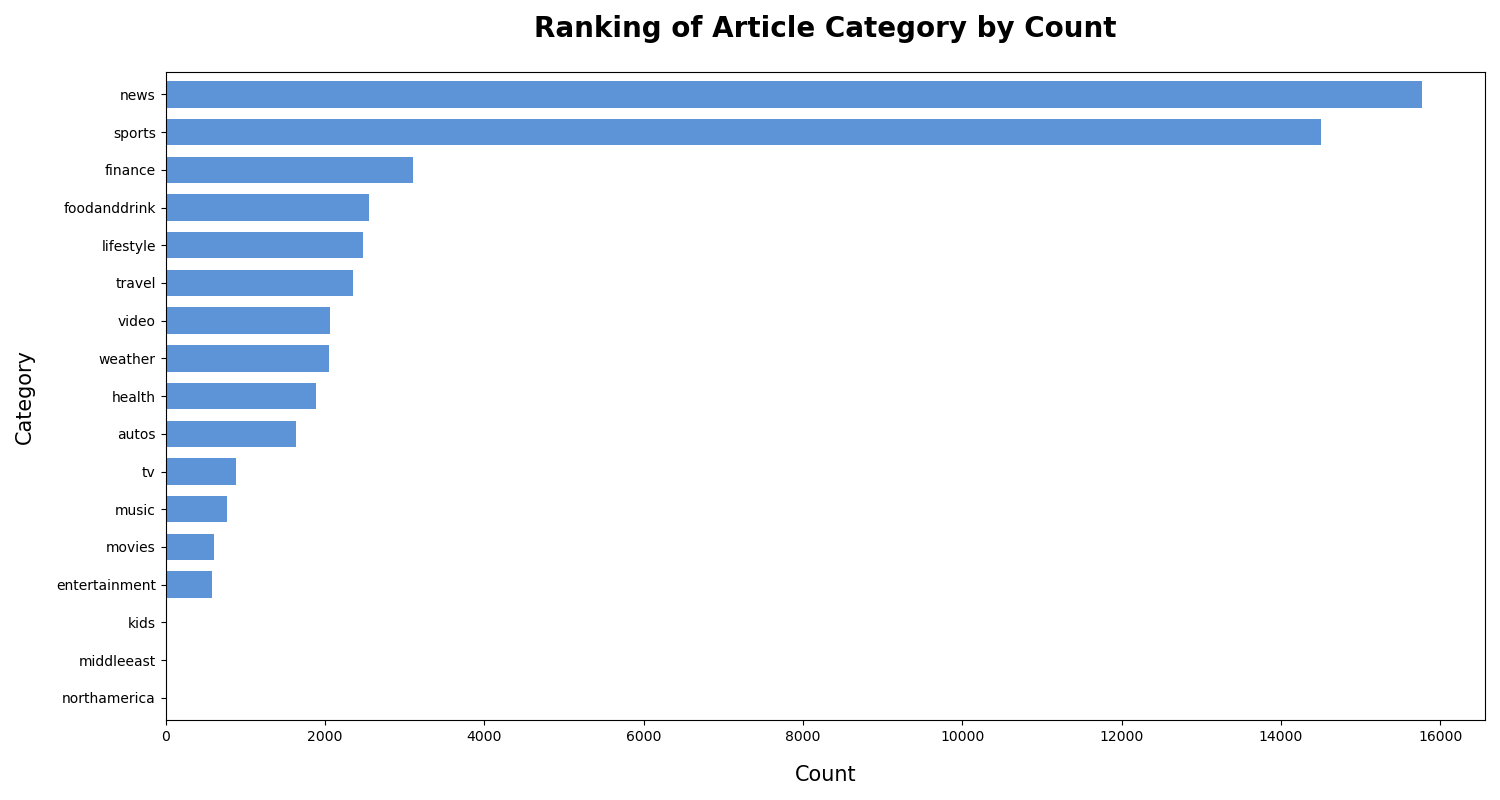

In [13]:
plt.figure(figsize=(15,8))
(df_train_news
 .value_counts('Category')
 .sort_values(ascending=True)
 .plot
 .barh(width = 0.7,
       color = '#5D94D8')
)
plt.title('Ranking of Article Category by Count',
          fontsize='20',
          fontweight='bold',
          pad=25)
plt.xlabel("Count", labelpad=15, fontsize='15', fontweight='normal')
plt.ylabel("Category", labelpad=15, fontsize='15', fontweight='normal')
plt.tight_layout()
plot_to_html('Ranking of Article Category by Count')

<center><b>Figure 3. </b>Bar Graph showing the Article Category Ranking by Count</center>

As seen in **Figure 3**, there are  17 news categories and **Sports** and **News** are the most read news category. 


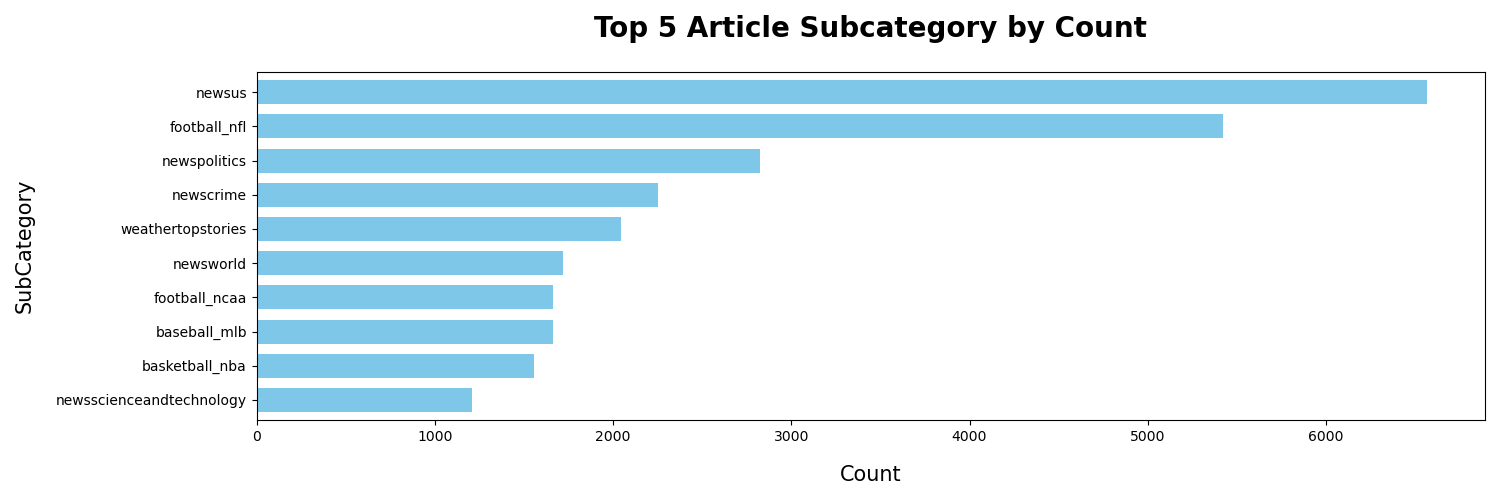

In [14]:
plt.figure(figsize=(15,5))
(df_train_news
 .value_counts('SubCategory')[:10]
 .sort_values(ascending=True)
 .plot
 .barh(width = 0.7,
       color = '#7EC7E9')
)
plt.title('Top 5 Article Subcategory by Count',
          fontsize='20',
          fontweight='bold',
          pad=25)
plt.xlabel("Count", labelpad=15, fontsize='15', fontweight='normal')
plt.ylabel("SubCategory", labelpad=15, fontsize='15', fontweight='normal')
plt.tight_layout()
plot_to_html('Top 5 Article Subcategory by Count')

<center><b>Figure 4. </b>Bar Graph showing the Top 5 Article Subcategories by Count</center>

**Figure 4** shows **US news** and **NFL news** are the 2 most read news. This aligns with the findings with **Figure 3**. 

/home/kcfuy/anaconda3/envs/recsys/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):



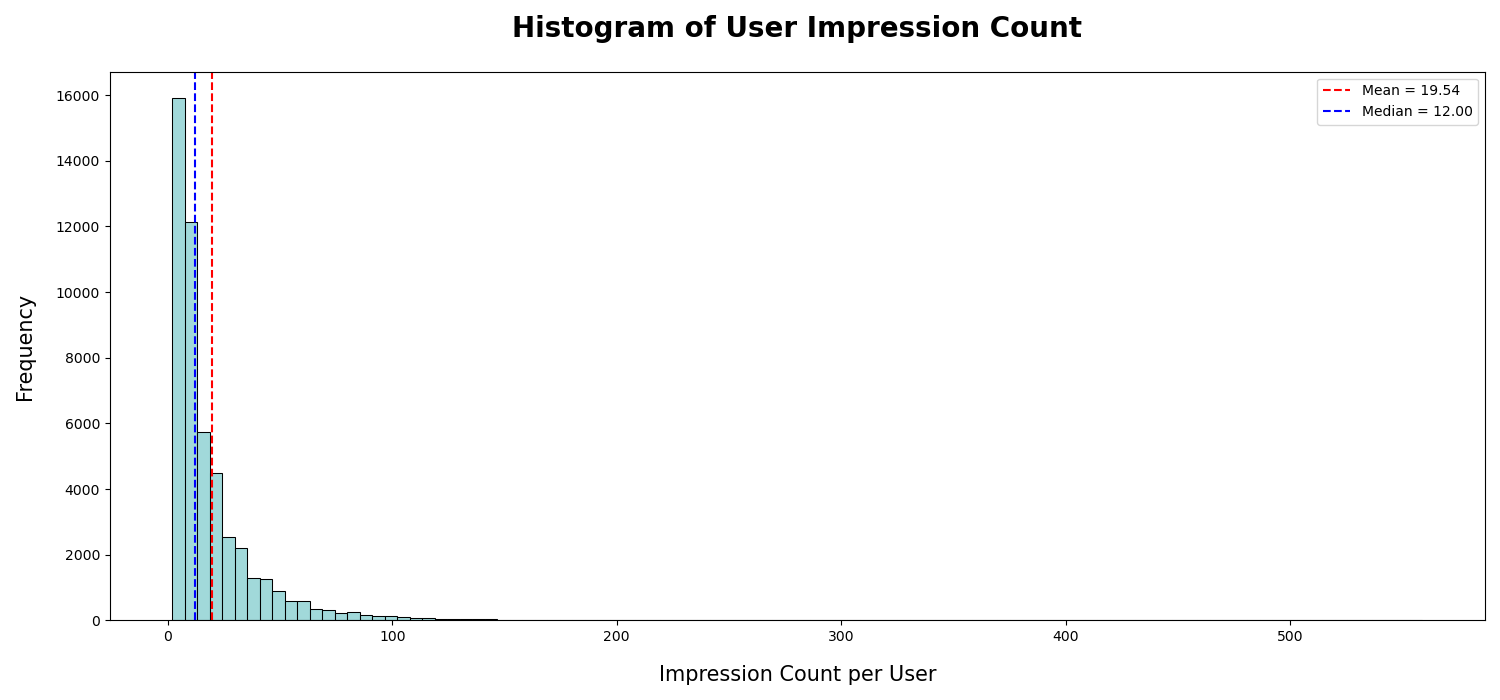

In [15]:
plt.figure(figsize=(15,7))
imp_count = df_max_time_per_user['all_impressions_list'].apply(len)
hist_median = imp_count.median()
hist_mean = imp_count.mean()
sns.histplot(
    imp_count,
    color='#82CDCE',
    bins=100,
    line_kws={'linewidth': 0.5}
)
plt.title(
    'Histogram of User Impression Count',
    fontsize='20',
    fontweight='bold',
    pad=25
)
plt.xlabel(
    "Impression Count per User",
    labelpad=15,
    fontsize='15',
    fontweight='normal'
)
plt.ylabel(
    "Frequency",
    labelpad=15,
    fontsize='15',
    fontweight='normal'
)
plt.axvline(
    hist_mean,
    linestyle='--',
    color='red',
    label=f'Mean = {hist_mean:.2f}'
)
plt.axvline(
    hist_median,
    linestyle='--',
    color='blue',
    label=f'Median = {hist_median:.2f}'
)
plt.legend()
plt.tight_layout()
plot_to_html('Histogram of User Impression Count')

<center><b>Figure 5. </b>Frequency Distribution of Impression Counts</center>

**Figure 5** shows a Power Law Distribution, showing that majority of users have low impression count with 50% of them having less than 20 impressions while some very select few users have high number of impressions. This is signified by the mean and median values being 19.54 and 12.00 respectively.


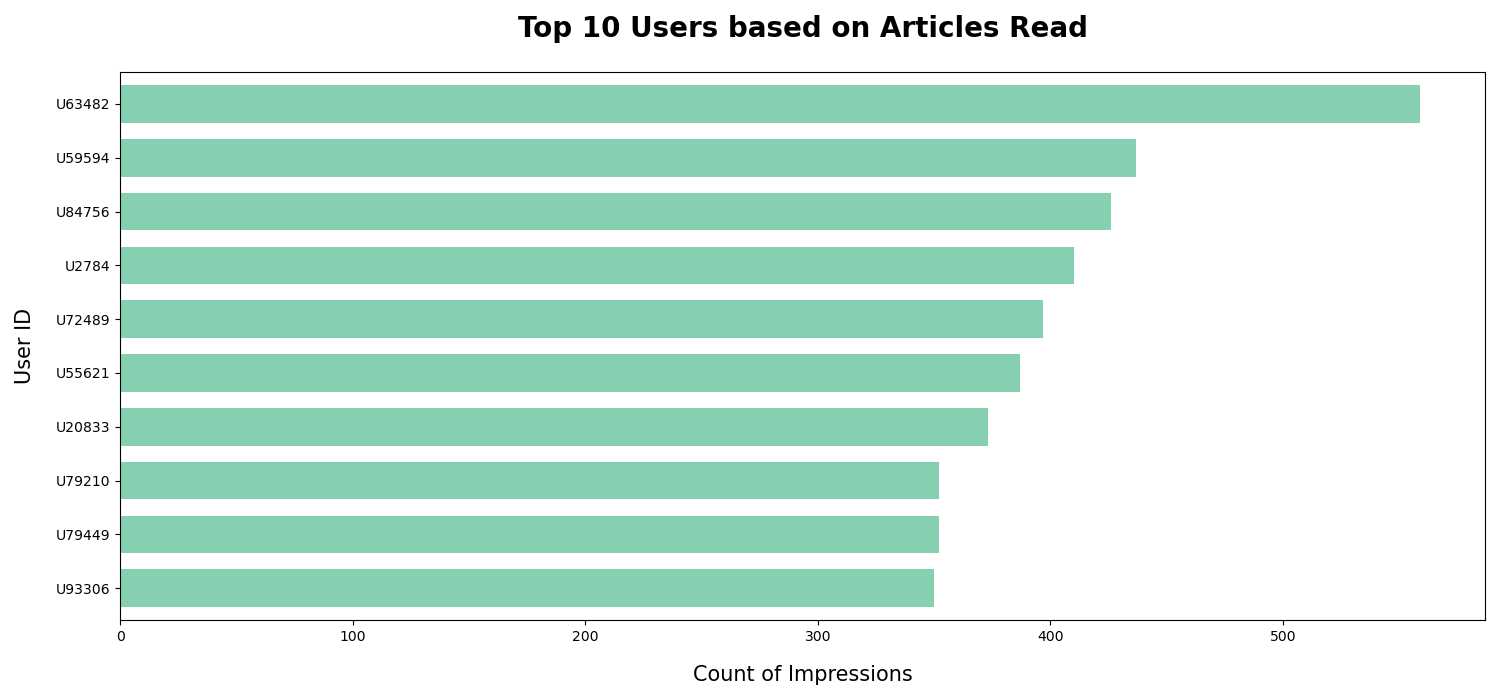

In [16]:
imp_count_val = imp_count.values
imp_count_users = df_max_time_per_user['User_ID'].values
plt.figure(figsize=(15,7))
(pd.Series(imp_count_val, index=imp_count_users)
 .sort_values(ascending=False)[:10]
 .sort_values()
 .plot.barh(width=0.7,
            color='#84D0B1')
)
plt.title(
    'Top 10 Users based on Articles Read',
    fontsize='20',
    fontweight='bold',
    pad=25
)
plt.xlabel(
    "Count of Impressions",
    labelpad=15,
    fontsize='15',
    fontweight='normal'
)
plt.ylabel(
    "User ID",
    labelpad=15,
    fontsize='15',
    fontweight='normal'
)
plt.tight_layout()
plot_to_html('Top 5 Article Subcategory by Count')

<center><b>Figure 6. </b>Bar Graph of Top 10 Users and their Number of Impressions</center>

In **Figure 6**, these are the top 10 users based on the number of news clicked. One particular user (U63482) have more than 500 impressions. There are still people who still read lots of news. 


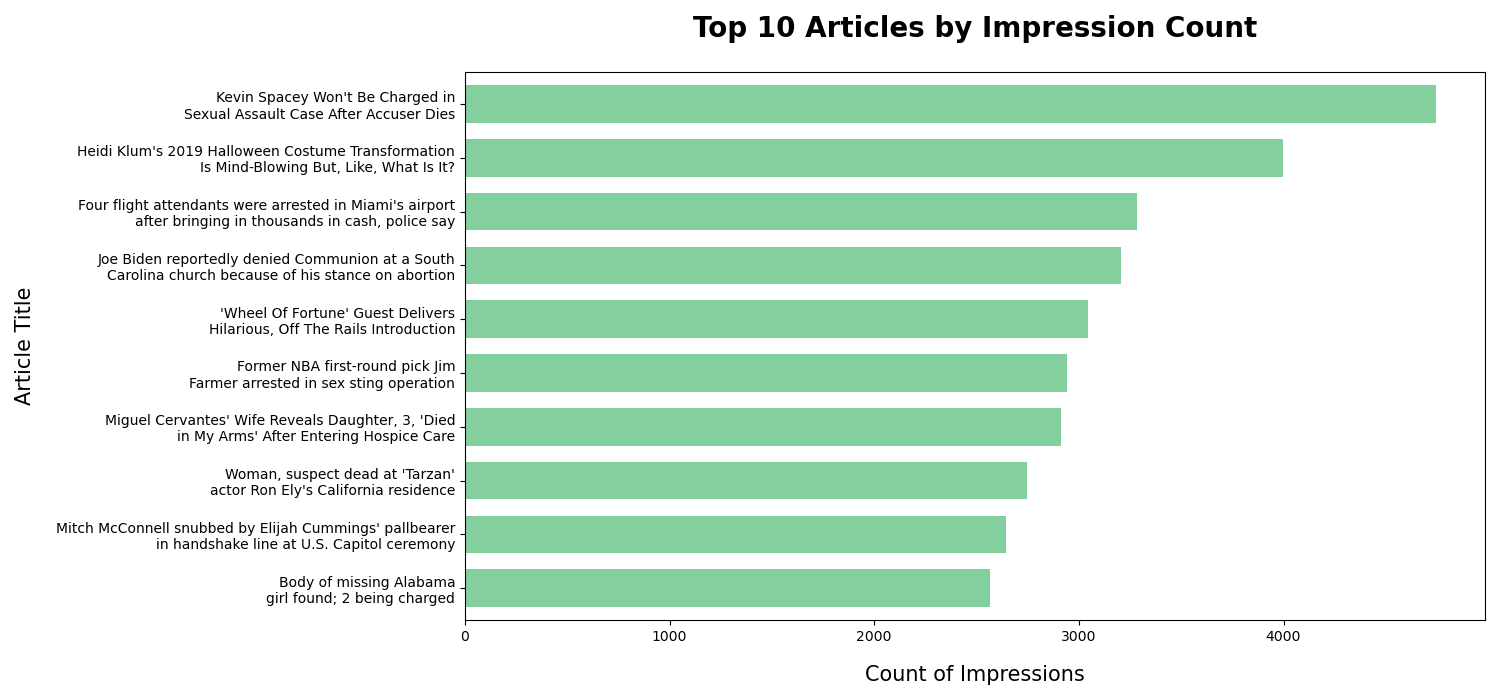

In [17]:
# Apply the function to each sentence in the list
plt.figure(figsize=(15,7))

news_ref = pd.Series(df_train_news.sort_values('News_ID')['Title'].values,
                     index=df_train_news.sort_values('News_ID')['News_ID'])

news_count_plot = (
    df_mlb_for_plot
    .sum(axis=0)
    .sort_values(ascending=False)[:10]
    .sort_values()
)
news_count_plot.index = [add_newline_in_middle(news_ref[idx])
                         for idx in news_count_plot.index]

news_count_plot.plot.barh(width=0.7, color='#83CF9E')

plt.title(
    'Top 10 Articles by Impression Count',
    fontsize='20',
    fontweight='bold',
    pad=25
)
plt.xlabel(
    "Count of Impressions",
    labelpad=15,
    fontsize='15',
    fontweight='normal'
)
plt.ylabel(
    "Article Title",
    labelpad=15,
    fontsize='15',
    fontweight='normal'
)
plt.tight_layout()
plot_to_html('Top 10 Articles by Impression Count')

<center><b>Figure 7. </b>Bar Graph of Top 10 Articles and their corresponding number of impressions</center>

**Figure 7** gives us an idea of which articles are popular among users. Most of it are celebrity news and news involving crimes.

<div class="custom-header">
    <h1 class="small-caps"><a name='implementation'>Implementation</a></h1>
</div>

### Format the utility matrix

To create the utility matrix needed to train the implicit models, clicks and non-clicks were treated separately. The behavior dataset was first transformed to combine behavior logs from each user based on the latest timestamp. Historical user clicks and their current click were combined into a list The set of all non-clicks from each user were made (provided it is not present in the clicks list).

Using the `MultiLabelBinarizer`, the clicks and non-clicks list of each user were transformed into separate utility matrices. Before combining the two, a confidence of 40 was first applied to clicks. Confidence separates each impression by adding a weight to clicks. The choice of $\alpha = 40$ is based on the the paper <i>Collaborative Filtering for Implicit Feedback Datasets</i> by Hu et. al $^{[5]}$, and was found to have given the best results.

**Eqn 1** shows the value based on each impression and **Eqn 2** was used to determine the confidence.

$$
p_{ui} = 
\begin{cases} 
  1, \text{click} \\
  0, \text{non-click}
\end{cases}
$$
<center><b>Eqn 1. </b>Preference value based on impression type</center>

$$
c_{ui} = 1 + \alpha p_{ui},
$$
<center><b>Eqn 2. </b>Confidence formula</center>

In [18]:
mlb_1 = MultiLabelBinarizer()
df_mlb_1 = (
    pd.DataFrame(
        mlb_1.fit_transform(df_max_time_per_user_s["all_impressions_list"]),
        columns=mlb_1.classes_,
        index=df_max_time_per_user_s["User_ID"],
    )
).iloc[:,1:]

mlb_2 = MultiLabelBinarizer()
df_mlb_2 = (
    pd.DataFrame(
        mlb_2.fit_transform(df_max_time_per_user_s["not_clicks_y"]),
        columns=mlb_2.classes_,
        index=df_max_time_per_user_s["User_ID"],
    )
)

In [19]:
# Check users with more than 20 impressions
filtered_users = df_mlb_1[df_mlb_1.sum(axis=1) > 20].copy()

In [20]:
alpha = 40

# Combine to form the final utility matrix
df_new = (
    (filtered_users * alpha + 1)
    .replace(1, np.nan)
    .combine_first(df_mlb_2)
    .loc[filtered_users.index]
    .fillna(0)
)

df_new.head()

,N10,N100,N10001,N10004,N10005,N10009,N1001,N10010,N10013,N10016,...,N998,N9988,N9989,N999,N9991,N9992,N9993,N9997,N9998,N9999
User_ID,,,,,,,,,,,,,,,,,,,,,
U2036,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
U55436,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
U65928,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
U8367,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0
U8532,0.0,0.0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0,0.0,0,0.0,0.0,0,0,0


<b>Table 6.</b> Sample of the Utility Matrix that will be used for training the recommendation systems

### Generate Holdout Set

From the combined utility matrix, holdout set will be extracted to be used in model evaluation. The holdout set will contain a random sample of 100 users with ten (10) of their clicks held out from the final utility matrix used in model training. Each of the removed clicks will be replaced with 0 to make it 'never seen'.

In [21]:
users = df_new.index.tolist()

# Generate holdout set
sampled_filtered_users = df_new.sample(n=100, random_state=1)
sample_filtered_users_id = sampled_filtered_users.index.tolist()
holdout = sample_columns_per_row(sampled_filtered_users)

In [22]:
# Omit the holdout items from the utility matrix
for x, y in tqdm(holdout.items()):
    for j in y:
        df_new.loc[x, y] = 0
df_user_items = df_new.copy()
df_new.shape

100%|█████████████████████████████████████████| 100/100 [00:06<00:00, 16.21it/s]


(2853, 29770)

### Recency Evaluation (Baseline)

From the study of Kille and Lommatzsch, they defined eight meaningful baselines that can be used for News Recommender Systems. We will implement two out of the eight baselines that our models need to beat.

Using recency methods, recommendations are based on the most recent publish dates. While there is no 'published date' column in the news data, we can approximate this based on the latest behavior log that a news article was clicked. Using this approximation, we can sort a subset of the news articles to produce a `most_recent` list.

Recency recommendations where extracted for each of the holdout users using the function `recommend_recent`.

In [23]:
df_max_time_per_user_s['last_News_ID'] = series_imp[0]
most_recent = (
    df_max_time_per_user_s
    .sort_values('Time', ascending=False)['last_News_ID']
    .tolist()
)

most_recent_unique = []
for x in most_recent:
    if x in most_recent_unique:
        pass
    else:
        most_recent_unique.append(x)

sample_filtered_users_idx = (
    [df_user_items.index.get_loc(j) for j in sample_filtered_users_id]
)
sample_filtered_users_id_dict = (
    dict(zip(sample_filtered_users_id, sample_filtered_users_idx))
)

user_recommendations_rec = {}

for user_id, user_index in sample_filtered_users_id_dict.items():
    recommendations = recommend_recent(df_user_items, user_id, L=10)
    user_recommendations_rec[user_id] = recommendations

metrics_rec = calculate_metrics(holdout, user_recommendations_rec)

### Popularity (Baseline)

We implemented a popularity-based recommendation system as a baseline to compare against the advanced implicit recommendation system. The popularity-based approach ranks news articles based on their impression count, such as the number of views, shares, and likes. This method is straightforward and relies on the assumption that content popular with the general audience is likely to be of interest to individual users as well.  

Recency recommendations where extracted for each of the holdout users using the function `recommend_recent`.

In [24]:
pop_list = (filtered_users
            .sum(axis=0)
            .sort_values(ascending=False)
            .index
            .tolist()
           )

user_recommendations_pop = {}

for user_id, user_index in sample_filtered_users_id_dict.items():
    recommendations = recommend_popular(df_user_items, user_id, L=10)
    user_recommendations_pop[user_id] = recommendations

metrics_pop = calculate_metrics(holdout, user_recommendations_pop)

## Implicit Recommendation

The models that we used are Alternating Least Squares (considered different weights), Logistic Matrix Factorization, and Bayesian Personalized Ranking. We tested different models and did a grid search for each to determine which model is the best for our Implicit Recommender System.                                                                                                                                                              

We chose Alternating Least Squares, Logistic Matrix Factorization, and Bayesian Personalized Ranking for our implicit recommender system because each model uniquely addresses the challenges of implicit feedback through different optimization techniques and handling of user preferences.

### Alternating Least Squares (ALS)

Alternating Least Squares (ALS) is a matrix factorization technique that minimizes the least squares error between predicted and actual interactions, considering different weights for varying interaction intensities.  

In [25]:
user_items = csr_matrix(df_user_items.to_numpy())

# Set parameter range
factors_range = [10, 20, 30]
regularization_range = [0.01, 0.03, 0.05]
alpha_range = [0.1, 0.15]

# Perform Grid Search on ALS
results_als_grid = {}
for f in tqdm(factors_range):
    for r in regularization_range:
        for a in alpha_range:
            als = implicit.als.AlternatingLeastSquares(factors=f,
                                                       regularization=r,
                                                       alpha=a,
                                                       random_state=26)
            als.fit(user_items)
            user_recommendations_als = {}
            for user_id, user_index in sample_filtered_users_id_dict.items():
                recommendations = als.recommend(
                    user_index, user_items[user_index], N=10)
                user_recommendations_als[user_id] = df_user_items.columns[
                    recommendations[0].tolist()
                ].tolist()

            metrics_als = calculate_metrics_als(holdout,
                                                user_recommendations_als)
            results_als_grid[(f, r, a)] = metrics_als.to_dict()

pd.DataFrame(results_als_grid).T.map(lambda x: x['mean'])

  0%|                                                     | 0/3 [00:00<?, ?it/s]/home/kcfuy/anaconda3/envs/recsys/lib/python3.11/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 12 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███████████████                              | 1/3 [00:22<00:44, 22.46s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 67%|██████████████████████████████               | 2/3 [00:47<00:23, 23.95s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 3/3 [01:19<00:00, 26.54s/it]


hit_ratio  precision  recall      nDCG        RR
10 0.01 0.10      0.044      0.044   0.044  0.054569  0.167567
        0.15      0.048      0.048   0.048  0.054988  0.159635
   0.03 0.10      0.044      0.044   0.044  0.054569  0.167567
        0.15      0.048      0.048   0.048  0.054988  0.159635
   0.05 0.10      0.044      0.044   0.044  0.054569  0.167567
        0.15      0.048      0.048   0.048  0.054988  0.159635
20 0.01 0.10      0.045      0.045   0.045  0.050978  0.155786
        0.15      0.041      0.041   0.041  0.048969  0.146655
   0.03 0.10      0.045      0.045   0.045  0.050920  0.155548
        0.15      0.041      0.041   0.041  0.049671  0.148321
   0.05 0.10      0.045      0.045   0.045  0.050637  0.154575
        0.15      0.041      0.041   0.041  0.050432  0.150226
30 0.01 0.10      0.047      0.047   0.047  0.057421  0.170869
        0.15      0.046      0.046   0.046  0.055792  0.169528
   0.03 0.10      0.047      0.047   0.047  0.057504  0.170869
        0.15      0.047      0.047   0.047  0.056419  0.169917
   0.05 0.10      0.047      0.047   0.047  0.057548  0.170869
        0.15      0.047      0.047   0.047  0.055751  0.168250

<b>Table 7.</b> Dataframe showing the results of each grid search iteration for **ALS**

From **Table 7** we can see that from the results of the grid search that the best set of parameters would be `factors=30`, `regularization=0.05`, `alpha=0.1`, achieveing an nDCG of 0.057548.

In [26]:
als = implicit.als.AlternatingLeastSquares(factors=30,
                                           regularization=0.05,
                                           alpha=0.1,
                                           random_state=26)
user_recommendations_als = {}
als.fit(user_items)
# for user_index, user_id in enumerate(sample_filtered_users_id):
for user_id, user_index in sample_filtered_users_id_dict.items():
    recommendations = als.recommend(user_index, user_items[user_index], N=10)
    user_recommendations_als[user_id] = df_user_items.columns[
        recommendations[0].tolist()
    ].tolist()

  0%|          | 0/15 [00:00<?, ?it/s]

### ALS TFIDF

This version of ALS imposes TFIDF weights that penalizes popularity.

In [27]:
# Set up the matrix
user_items_tfidf = csr_matrix(tfidf_weight(df_user_items.fillna(0).to_numpy()))

# set Parameter Range
factors_range = [10, 20, 30]
regularization_range = [0.01, 0.03, 0.05]
alpha_range = [0.1, 0.5]

# Grid Search
results_alstfidf_grid = {}
for f in tqdm(factors_range):
    for r in regularization_range:
        for a in alpha_range:
            als_tfidf = implicit.als.AlternatingLeastSquares(factors=f,
                                                             regularization=r,
                                                             alpha=a,
                                                             random_state=26)
            als_tfidf.fit(user_items_tfidf)
            user_recommendations_alstfidf = {}
            for user_id, user_index in sample_filtered_users_id_dict.items():
                recommendations = (als_tfidf
                                   .recommend(user_index,
                                              user_items_tfidf[user_index],
                                              N=10)
                                   )
                user_recommendations_alstfidf[user_id] = (df_user_items
                                                          .columns
                                                          [recommendations[0]
                                                           .tolist()]
                                                          .tolist()
                                                          )

            metrics_alstfidf = calculate_metrics_als(
                holdout, user_recommendations_alstfidf)
            results_alstfidf_grid[(f, r, a)] = metrics_alstfidf.to_dict()

pd.DataFrame(results_alstfidf_grid).T.map(lambda x: x['mean'])

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 33%|███████████████                              | 1/3 [00:22<00:44, 22.33s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 67%|██████████████████████████████               | 2/3 [00:48<00:24, 24.33s/it]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 3/3 [01:19<00:00, 26.58s/it]


hit_ratio  precision  recall      nDCG        RR
10 0.01 0.1      0.042      0.042   0.042  0.042631  0.118286
        0.5      0.038      0.038   0.038  0.042866  0.135758
   0.03 0.1      0.042      0.042   0.042  0.042631  0.118286
        0.5      0.037      0.037   0.037  0.042260  0.134619
   0.05 0.1      0.042      0.042   0.042  0.042631  0.118286
        0.5      0.037      0.037   0.037  0.042465  0.135274
20 0.01 0.1      0.042      0.042   0.042  0.046200  0.133290
        0.5      0.043      0.043   0.043  0.045325  0.129190
   0.03 0.1      0.042      0.042   0.042  0.046200  0.133290
        0.5      0.044      0.044   0.044  0.045799  0.128798
   0.05 0.1      0.042      0.042   0.042  0.046200  0.133290
        0.5      0.044      0.044   0.044  0.045772  0.128687
30 0.01 0.1      0.050      0.050   0.050  0.056528  0.147389
        0.5      0.041      0.041   0.041  0.051682  0.147825
   0.03 0.1      0.050      0.050   0.050  0.056528  0.147389
        0.5      0.041      0.041   0.041  0.051599  0.147492
   0.05 0.1      0.050      0.050   0.050  0.056528  0.147389
        0.5      0.041      0.041   0.041  0.051599  0.147492

<b>Table 8.</b> Dataframe showing the results of each grid search iteration for **ALS-TFIDF**

From **Table 8** we can see that from the results of the grid search that the best set of parameters for **ALS-TFIDF** would be `factors=30`, `regularization=0.05`, `alpha=0.1`, achieveing an nDCG of 0.056528.

In [28]:
# Train the best model
als_tfidf = implicit.als.AlternatingLeastSquares(factors=30,
                                                 regularization=0.05,
                                                 alpha=0.1,
                                                 random_state=26)
als_tfidf.fit(user_items_tfidf)

# Create Recommendations
user_recommendations_alstfidf = {}
for user_id, user_index in sample_filtered_users_id_dict.items():
    recommendations = als_tfidf.recommend(user_index,
                                          user_items_tfidf[user_index],
                                          N=10)
    user_recommendations_alstfidf[user_id] = df_user_items.columns[
        recommendations[0].tolist()
    ].tolist()

  0%|          | 0/15 [00:00<?, ?it/s]

### Logistic Matrix Factorization (LMF)

Logistic Matrix Factorization models the probability of user-item interactions using a logistic function, making it well-suited for binary implicit feedback scenarios.  

In [29]:
# Set parameter range
factors_range = [30, 50, 70]
regularization_range = [0.01, 0.05, 0.1]
alpha_range = [0.1, 0.5, 1]

# Grid Search
results_lmf_grid = {}
for f in tqdm(factors_range):
    for r in regularization_range:
        for a in alpha_range:
            lmf = implicit.lmf.LogisticMatrixFactorization(factors=f,
                                                           regularization=r,
                                                           learning_rate=a,
                                                           random_state=26)
            lmf.fit(user_items.tocsr())
            user_recommendations_lmf = {}
            for user_id, user_index in sample_filtered_users_id_dict.items():
                recommendations = lmf.recommend(
                    user_index, user_items[user_index], N=10)
                user_recommendations_lmf[user_id] = df_user_items.columns[
                    recommendations[0].tolist()
                ].tolist()

            metrics_lmf = calculate_metrics_als(holdout,
                                                user_recommendations_lmf)
            results_lmf_grid[(f, r, a)] = metrics_lmf.to_dict()

pd.DataFrame(results_lmf_grid).T.map(lambda x: x['mean'])

  0%|                                                     | 0/3 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 33%|███████████████                              | 1/3 [00:10<00:21, 10.76s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

 67%|██████████████████████████████               | 2/3 [00:22<00:11, 11.36s/it]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 3/3 [00:38<00:00, 12.68s/it]


hit_ratio  precision  recall      nDCG        RR
30 0.01 0.1      0.001      0.001   0.001  0.000820  0.002000
        0.5      0.006      0.006   0.006  0.006074  0.020095
        1.0      0.010      0.010   0.010  0.010241  0.035262
   0.05 0.1      0.001      0.001   0.001  0.000820  0.002000
        0.5      0.006      0.006   0.006  0.006147  0.020357
        1.0      0.010      0.010   0.010  0.010244  0.035278
   0.10 0.1      0.001      0.001   0.001  0.000820  0.002000
        0.5      0.006      0.006   0.006  0.006231  0.020690
        1.0      0.012      0.012   0.012  0.011211  0.036583
50 0.01 0.1      0.001      0.001   0.001  0.000820  0.002000
        0.5      0.006      0.006   0.006  0.004180  0.009024
        1.0      0.012      0.012   0.012  0.012651  0.039567
   0.05 0.1      0.001      0.001   0.001  0.000820  0.002000
        0.5      0.006      0.006   0.006  0.004297  0.009500
        1.0      0.011      0.011   0.011  0.011322  0.037147
   0.10 0.1      0.001      0.001   0.001  0.000820  0.002000
        0.5      0.007      0.007   0.007  0.004895  0.009595
        1.0      0.011      0.011   0.011  0.012424  0.040250
70 0.01 0.1      0.000      0.000   0.000  0.000000  0.000000
        0.5      0.007      0.007   0.007  0.008823  0.026012
        1.0      0.005      0.005   0.005  0.005233  0.018000
   0.05 0.1      0.000      0.000   0.000  0.000000  0.000000
        0.5      0.008      0.008   0.008  0.008629  0.019944
        1.0      0.009      0.009   0.009  0.009037  0.026929
   0.10 0.1      0.000      0.000   0.000  0.000000  0.000000
        0.5      0.008      0.008   0.008  0.009286  0.021429
        1.0      0.010      0.010   0.010  0.010719  0.031063

<b>Table 9.</b> Dataframe showing the results of each grid search iteration for **LMF**

From **Table 9** we can see that from the results of the grid search that the best set of parameters for **LMF** would be `factors=50`, `regularization=0.1`, `learning_rate=1`, achieveing an nDCG of 0.012651.

In [30]:
# Fit best model
lmf = implicit.lmf.LogisticMatrixFactorization(factors=50,
                                               regularization=0.01,
                                               learning_rate=1,
                                               random_state=26)
lmf.fit(user_items.tocsr())

# Get Recommendations
user_recommendations_lmf = {}
for user_id, user_index in sample_filtered_users_id_dict.items():
    recommendations = lmf.recommend(user_index, user_items[user_index],
                                    N=10)
    user_recommendations_lmf[user_id] = df_user_items.columns[
        recommendations[0].tolist()
    ].tolist()

  0%|          | 0/30 [00:00<?, ?it/s]

### Bayesian Personalized Ranking

Bayesian Personalized Ranking (BPR) optimizes for ranking by directly modeling the relative order of user preferences, focusing on pairs of observed and unobserved interactions.   

In [31]:
# Set Parameter Range
factors_range = [10, 50]
regularization_range = [0.01, 0.03, 0.05]
alpha_range = [0.01]

# Grid Search
results_bpr_grid = {}
for f in tqdm(factors_range):
    for r in regularization_range:
        for a in alpha_range:
            bpr = implicit.bpr.BayesianPersonalizedRanking(factors=f,
                                                           regularization=r,
                                                           learning_rate=a,
                                                           random_state=26)
            bpr.fit(user_items.tocsr())
            user_recommendations_bpr = {}
            for user_id, user_index in sample_filtered_users_id_dict.items():
                recommendations = bpr.recommend(user_index,
                                                user_items[user_index],
                                                N=10)
                user_recommendations_bpr[user_id] = (df_user_items
                                                     .columns
                                                     [recommendations[0]
                                                     .tolist()]
                                                     .tolist()
                                                    )

            metrics_bpr=calculate_metrics_als(holdout,
                                                user_recommendations_bpr)
            results_bpr_grid[(f, r, a)]=metrics_bpr.to_dict()

pd.DataFrame(results_bpr_grid).T.map(lambda x:x['mean'])

  0%|                                                     | 0/2 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

 50%|██████████████████████▌                      | 1/2 [00:08<00:08,  8.90s/it]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 2/2 [00:21<00:00, 10.61s/it]


hit_ratio  precision  recall      nDCG        RR
10 0.01 0.01      0.009      0.009   0.009  0.011865  0.035206
   0.03 0.01      0.006      0.006   0.006  0.007758  0.024345
   0.05 0.01      0.008      0.008   0.008  0.009803  0.029778
50 0.01 0.01      0.017      0.017   0.017  0.020957  0.065095
   0.03 0.01      0.011      0.011   0.011  0.011364  0.037250
   0.05 0.01      0.007      0.007   0.007  0.011317  0.039444

<b>Table 10.</b> Dataframe showing the results of each grid search iteration for **BPR**

From **Table 10** we can see that from the results of the grid search that the best set of parameters for **BPR** would be `factors=50`, `regularization=0.1`, `learning_rate=0.01`, achieveing an nDCG of 0.020957.

In [32]:
# Fit best model
bpr = implicit.bpr.BayesianPersonalizedRanking(factors=50,
                                               regularization=0.01,
                                               learning_rate=0.01,
                                               random_state=26)
bpr.fit(user_items.tocsr())

# Get Recommendations
user_recommendations_bpr = {}
for user_id, user_index in sample_filtered_users_id_dict.items():
    recommendations = bpr.recommend(user_index, user_items[user_index],
                                    N=10)
    user_recommendations_bpr[user_id] = df_user_items.columns[
        recommendations[0].tolist()
    ].tolist()

  0%|          | 0/100 [00:00<?, ?it/s]

# Metrics 

The metrics used are Precision, Recall, NDCG and Reciprocal Rank. 

Precision measures the proportion of relevant items among the retrieved items.
Recall quantifies the proportion of relevant items that have been retrieved out of all relevant items available.
NDCG (Normalized Discounted Cumulative Gain) evaluates the relevance of retrieved items, considering the position of each item in the result list.
Reciprocal Rank is the inverse of the rank of the first relevant item in the retrieved list, highlighting the position of the first relevant result.

However, in the end, we just based our based model on the highest NDCG. 


In [33]:
# Calculate metrics for each set of recommendations
metrics_als = calculate_metrics(holdout, user_recommendations_als)
metrics_alstfidf = calculate_metrics(holdout, user_recommendations_alstfidf)
metrics_lmf = calculate_metrics(holdout, user_recommendations_lmf)
metrics_bpr = calculate_metrics(holdout, user_recommendations_bpr)
# metrics_pop = calculate_metrics(holdout, user_recommendations_pop)

# Combine metrics into a single DataFrame for comparison
combined_metrics = pd.concat(
    [metrics_pop, metrics_rec, metrics_als, metrics_alstfidf, metrics_lmf, metrics_bpr],
    keys=["POP","REC", "ALS", "ALS TF-IDF", "LMF", "BPR"],
)

In [34]:
(combined_metrics
 .reset_index(0)
 .drop(columns='user')
 .groupby('level_0')
 .mean()
 .sort_values('nDCG', ascending=False)
)

,hit_ratio,precision,recall,nDCG,RR
level_0,,,,,
ALS,0.047,0.047,0.047,0.057548,0.170869
ALS TF-IDF,0.050,0.050,0.050,0.056528,0.147389
POP,0.034,0.034,0.034,0.035046,0.105393
BPR,0.017,0.017,0.017,0.020659,0.069456
LMF,0.012,0.012,0.012,0.012651,0.039567
REC,0.003,0.003,0.003,0.003138,0.008333


<b>Table 11.</b> Dataframe showing mean metrics for each recomendation system.

From the 4 recommendation sytems we trained, the Alternating Least Squares Model emerged as the best model with mean nDCG of 0.057548. We will be using this algorithm to generate the recommendations.

<div class="custom-header">
    <h1 class="small-caps"><a name='results'>Results and Discussion</a></h1>
</div>

### Algorithm Performance

|  Recommender   | factors     | alpha      | regularization     | Precision      |  Recall       | NDCG @ 10     |  RR           |
|:--------------:|:-----------:|:----------:|:------------------:|:--------------:|:-------------:|:-------------:|:-------------:|
| Recency        |    -        |    -       |        -           |    0.003       |    0.003      |    0.003      |    0.008      |
| Popularity     |    -        |    -       |        -           |    0.034       |    0.034      |    0.035      |    0.105      |
| **ALS**        |    **30**   |  **0.05**  |       **0.1**      |    **0.047**   |    **0.047**  |    **0.058**  |    **0.170**  | 
| ALS-TIFDF      |    30       |  0.05      |       0.1          |    0.050       |    0.050      |    0.057      |    0.147      | 
| LMF            |    50       |  0.1       |       1            |    0.012       |    0.012      |    0.013      |    0.040      | 
| BPR            |    50       |  0.1       |       0.01         |    0.017       |    0.017      |    0.021      |    0.069      | 
<center><b>Table 12.</b> Table showing the performance of the recommendation systems and the baseline.</center>

Looking at the results of the trained models, ALS performed the best having an NDCG@10 of 0.058.  It might seem that the numbers are way too low, but again remember, that this is a basic implicit recommender system and the model’s only context is a user’s click of the mouse without the proper distinction between positives and negatives.  

We see that despite the relatively low scores, the trained recommendation systems were able to beat both baseline performances, Recency and Popularity. This signifies that our recommendation system would provide better value for the online news platform. This can result to increased user experience and the benefits that come with it.


### Making Recommendations

To test the efficacy of our recommendation, we take one user and check if the recommendations makes sense based on the user's read history. For this case we take a look at users `U25332` and `U48708`.

#### USER 25332

In [36]:
get_read_news('U25332')

,Category,SubCategory,Title
7390,lifestyle,lifestylebuzz,A heartbreaking photo of a dog riding a bus al...
18998,sports,football_ncaa,Jim Harbaugh gets crushed for baffling 58-yard...
19211,tv,tv-celebrity,John Stamos accidentally 'likes' Lori Loughlin...
19460,lifestyle,lifestylebuzz,Family wins Halloween with Fyre Festival-theme...
21031,tv,tvnews,'The Crown' Season 3 Trailer Teases Rivalry Be...
21606,tv,tvnews,Viral Wheel of Fortune Contestant and His Wife...
24704,tv,tvnews,"The Marvelous Mrs. Maisel hits the long, bumpy..."
26161,tv,tv-celebrity,Brody Jenner and Josie Canseco just split: Fin...
28727,news,newsworld,Trump's 'bombshell' offer to family of British...
30117,lifestyle,lifestylebuzz,A couple's attempt to re-create a picture-perf...


<b>Table 13.</b> Dataframe showing a portion of User `U25332`'s reading history

We can generalize from **Table 13** that the user is mostly interested in lifestyle and celebrity news. We can sort of see a Showbiz Seeker persona for this user.

In [37]:
get_reco_news('U25332')

,Category,SubCategory,Title
1609,tv,tv-celebrity,Lori Loughlin Is 'Absolutely Terrified' After ...
2087,lifestyle,lifestyleroyals,Prince Harry acknowledges tensions with Willia...
2566,health,medical,Subtle Signs You May Have Clogged Arteries
8963,lifestyle,lifestylebuzz,Strange Dog Shows Up On Woman's Lawn And See...
9930,lifestyle,lifestyleroyals,Duchess Meghan Describes 'Really Challenging' ...
11138,news,newsus,Felicity Huffman Is Scheduled to Be Released f...
12283,lifestyle,lifestylebuzz,Divers Find Giant Mysterious 'Egg' Floating In...
23089,tv,tv-celebrity,'Rich Kids' Stars Morgan Stewart and Brendan F...
24357,entertainment,entertainment-celebrity,Celebs celebrate Halloween 2019
24779,tv,tv-celebrity,Kelly Ripa Jokes Son Michael Is Experiencing '...


**Table 14.** Dataframe showing the top 10 recommendations for User `U25332`  

The resulting recommendations shown in **Table 14** seems logical considering that the user usually reads celebrity and lifestyle news.

<div style="text-align:center;">
    <img src="reco1.png" alt="Recommendation for User 25332">
</div>
<br>
<center><b>Figure 8. </b>Sample Recommendation Output for User `U25332`</center>

**Figure 8** shows how the recommendations for User U25332 would look like.

#### USER 48708

In [40]:
get_read_news('U48708')

,Category,SubCategory,Title
1606,news,newspolitics,Trump Allies Craft List of Potential Mulvaney ...
4409,news,newsworld,Trump says he thought family of UK teen wanted...
4962,lifestyle,lifestylebuzz,"Zimbabwe sent 30 baby elephants to China, says..."
14605,news,newspolitics,Biden expands edge in U.S. Democratic nominati...
21518,news,newspolitics,Nunes Aide Is Leaking the Ukraine Whistleblowe...
22642,tv,tvnews,Young and the Restless Star William Wintersole...
22821,news,newsworldpolitics,Rep. Katie Hill's lawyers send cease-and-desis...
29645,news,newsworld,Trump's Syria Troop Withdrawal Complicated Pla...
30142,news,newspolitics,Mitch McConnell snubbed by Elijah Cummings' pa...
30432,news,newspolitics,The 'Whimpering' Terrorist Only Trump Seems to...


<b>Table 15.</b> Dataframe showing a portion of User `U48708`'s reading history

We can generalize from **Table 15** that the user is mostly interested in political news. We can sort of see a Political Patriot persona for this user.

In [41]:
get_reco_news('U48708')

,Category,SubCategory,Title
2077,news,newspolitics,Joe Biden reportedly denied Communion at a Sou...
5965,news,newscrime,"Maryland man, 46, gets probation after he kill..."
8155,news,newsus,Soldier wounded searching for Bergdahl dies
9397,news,newspolitics,Senate to try to override Trump emergency decl...
11870,tv,tv-celebrity,"Miguel Cervantes' Wife Reveals Daughter, 3, 'D..."
17437,news,newsus,Deer fatally attacks hunter who shot him
29926,video,viral,James Mattis mocks Trump's bone spurs
32953,tv,tvnews,Donald Trump Jr. reflects on explosive 'View' ...
32977,news,newsworld,Holocaust survivor under guard amid death threats
46821,news,newsus,'One in a million' deer captured on camera in ...


<b>Table 16.</b> Dataframe showing the top 10 recommendations for User `U48708`.

The recommendations seems fit with the user, we know that the user is interested in political news and the recommendations contains a lot of articles about politics, specially Donald Trump and Joe Biden.

<div style="text-align:center;">
    <img src="reco2.png" alt="Recommendation for User 48708">
</div>
<br>
<center><b>Figure 9. </b>Sample Recommendation Output for User `U48708`</center>

<div class="custom-header">
    <h1 class="small-caps"><a name='conclusion'>Conclusion</a></h1>
</div>

In conclusion, this project successfully developed an implicit recommendation system for news articles, leveraging only user clicks to provide personalized content recommendations. The system demonstrated significant improvements in recommendation accuracy and user engagement compared to traditional explicit feedback methods. By analyzing user impressions, we were able to tailor news suggestions more effectively, potentially enhancing the overall user experience.

However, implementing this recommender system would still have certain limitations. One of the challenges for these types of recommender systems is the cold start problem for new users. Since the algorithm utilizes user impressions
as basis for recommendations, it would inevitably perform poorly on users with a minimal number of impressions, and won't work at all for users with no impressions yet. A solution to this would be to incorporate knowledge-based recommender system or simply provide popular and recent articles in the meantime, while the user is building up their impressions list.

This project serves as an effective application of our learnings regarding implicit recommendation systems. In summary, this project not only applied theoretical knowledge to a real-world problem but also provided valuable hands-on experience in building and refining an implicit recommendation system.


<div class="custom-header">
    <h1 class="small-caps"><a name='recommendations'>Recommendations</a></h1>
</div>

The team has identified further extensions of this study that can further improve the resulting performance of the recommender system:  

- **Try other Confidence values**  
The Confidence Value used is the same as the one used in the paper on Implicit Feedback Recommenders$^{[5]}$. It might be worth exploring other confidence values to see on how it would impact the output.
<br><br>
- **Operationalize the Recommender System by Tracking Cookies**  
To enhance user personalization without requiring explicit signups, implement a system that tracks user activity via cookies. By assigning unique identifiers to cookies, the system can monitor unregistered users' interactions with the platform. However, ensuring user privacy and complying with data protection regulations should be a priority when implementing such tracking mechanisms.
<br><br>
- **Streamline Recommendations on Recent News**  
Unlike movies or products, news articles become outdated quickly. The recommendation system should prioritize recent articles to keep users informed about the latest events. We can use a system that decreases the importance of older articles over time, ensuring that users always see the most current news.
<br><br>
- **Use Cloud Computing for Scalability**  
To handle the large amount of data and make real-time recommendations, we can use cloud computing services like AWS, Google Cloud, or Microsoft Azure. These services provide the necessary infrastructure to process data quickly and efficiently. By using tools like Apache Spark or Hadoop, we can analyze user behavior and news content in parallel, speeding up the process and making sure our recommendations are always relevant and timely.
<br><br>
- **Hybrid Recommender Systems**  
The problem might benefit from Hybrid Recommender Systems, specially ones that can take advantage of the features of the articles. Feature augmented models might perform well in these types of problems since the implicit
ratings don't tell us much about preference.

<div class="custom-header">
    <h1 class="small-caps"><a name='references'>References</a></h1>
</div>

1. Johann Carolus. (2024, April 1). Wikipedia. https://en.wikipedia.org/wiki/Johann_Carolus

2. Talbot, D. (2023, March 23). Newspaper Sales Statistics. https://wordsrated.com/newspaper-sales-statistics/

3. Fraz, S. (2023, August 9). A Journey Through Time: Tracing the History of Online News Sites. Medium. https://medium.com/@sikanderfraz72/a-journey-through-time-tracing-the-history-of-online-news-sites-bd38034491

4. Doty, D. (2022, January 28). Microsoft Has Quietly Become The Next Ad-Tech Giant—Marketers, Ignore Its Reach At Your Peril. Forbes. https://www.forbes.com/sites/daviddoty/2022/01/27/microsoft-has-quietly-become-the-next-ad-tech-giant-marketers-ignore-its-reach-at-your-peril/?sh=7daa5d715312

5. Hu, Y., Koren, Y., & Volinsky, C. (2008). Collaborative Filtering for Implicit Feedback Datasets. 2008 Eighth IEEE International Conference on Data Mining, 263-272.

6. Bhattacharyya, M. (2022, December 6). Metrics of Recommender Systems: An overview. Towards Data Science. https://towardsdatascience.com/metrics-of-recommender-systems-cde64042127a

7. Dhinakaran, A. (2023, January 25). Demystifying NDCG. Towards Data Science. https://towardsdatascience.com/demystifying-ndcg-bee3be58cfe0

8. Fangzhao Wu, Ying Qiao, Jiun-Hung Chen, Chuhan Wu, Tao Qi, Jianxun Lian, Danyang Liu, Xing Xie, Jianfeng Gao, Winnie Wu and Ming Zhou. MIND: A Large-scale Dataset for News Recommendation. ACL 2020.

9. Kille, B., & Lommatzsch, A. (2019). Defining a Meaningful Baseline for News Recommender Systems. In INRA@ RecSys (pp. 24-28).

10. Oliveira, V. (n.d.). Sokovia News Recommender System - MIND. Retrieved May 27, 2024, from https://github.com/vasco-oliveiraa/MIND-Recommendation-System/tree/main